- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../../../voice_data/pathology_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/pathology_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    pathology.append(mel_feature)
    

#Healthy data
for audio_path in os.listdir('../../../voice_data/healthy_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/healthy_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    healthy.append(mel_feature)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  1194
healthy data 수 :  634
가장 긴 path sample : 318596
가장 긴 healthy sample : 207017


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

6.37192 초
4.14034 초


# 결과 확인
- 1 row당 1 frame으로

In [5]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
#headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
#pd.DataFrame(healthy[0].T,columns=headers)

print(healthy[0])




[[-40.589996 -39.998337 -38.81555  ... -38.37249  -39.136566 -37.830963]
 [-45.260597 -43.43311  -43.50158  ... -42.478107 -43.67787  -38.517254]
 [-56.9734   -49.211952 -54.667103 ... -49.667316 -53.020805 -38.752518]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


In [6]:
print(healthy[0].shape) #1번 주파수 축, 2번 시간축.
print(healthy[1].shape)

(128, 326)
(128, 338)


In [7]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [3]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('../../../voice_data/pathology_new/phrase/export/*.wav')
healthy = glob('../../../voice_data/healthy_new/phrase/export/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1194:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1194
Healthy:  634
총 데이터수 :  1828
---
훈련 셋 :  1462 Counter({'pathology': 955, 'healthy': 507})
테스트 셋 :  366 Counter({'pathology': 239, 'healthy': 127})
---


## 2. random over sampling

In [4]:
#2. random over sampling

X = np.array(X).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
#Y = np.array(Y)
ros = RandomOverSampler(random_state = 123)
X_res,Y_res = ros.fit_resample(X,Y)

print('before dataset shape {}'.format(Counter(Y)) )
print('Resampled dataset shape {}'.format(Counter(Y_res)) )


before dataset shape Counter({'pathology': 955, 'healthy': 507})
Resampled dataset shape Counter({'pathology': 955, 'healthy': 955})


In [5]:
#원래대로 돌리기
X=X_res.reshape(1, -1)
print( '총 데이터수 : ',X[0].size )
print(  '복사된 수 : ',X[0].size - np.unique(X[0]).size )

X=X[0].tolist()
Y=Y_res

총 데이터수 :  1910
복사된 수 :  448


In [6]:
print(X[0:4])
print(Y[0:4])

['../../../voice_data/pathology_new/phrase/export\\2231-phrase.wav', '../../../voice_data/healthy_new/phrase/export\\1124-phrase.wav', '../../../voice_data/pathology_new/phrase/export\\2340-phrase.wav', '../../../voice_data/pathology_new/phrase/export\\1611-phrase.wav']
['pathology', 'healthy', 'pathology', 'pathology']


In [12]:
#### train set 수를 줄이는 방법
#1. 500개만 고르기
X=X[0:500]
Y=Y[0:500]
#####



In [79]:
#2. 1000개만 고르기
X=X[0:1000]
Y=Y[0:1000]

In [7]:
#3. 1500개만
X=X[0:1500]
Y=Y[0:1500]

In [ ]:
#4. 그대로.

In [8]:
X

['../../../voice_data/pathology_new/phrase/export\\2231-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\1124-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\2340-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1611-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1157-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\705-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\1918-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1410-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\2130-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\2279-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1632-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\2240-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\1179-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\982-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\

## 3. stratified k-fold

In [9]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 436, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 109, 'pathology': 191} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 436, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 109, 'pathology': 191} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 436, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 109, 'pathology': 191} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 436, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 109, 'pathology': 191} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 436, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 109, 'pathology': 191} 



# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [10]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        #stft 500 FRAME이 되도록 패딩.
        length = 300
        mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        mel_feature = pad2d(mel_feature, length)
        
        
        if self.transform:
            #print('transform')
            mel_feature=self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            mel_feature=torch.stack([mel_feature,mel_feature,mel_feature])# 3채널로 복사.
            mel_feature = mel_feature.squeeze(dim=1)
        else:
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return mel_feature, self.classes.index(self.label[idx])
    

In [11]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        #stft 500 FRAME이 되도록 패딩.
        length = 300
        mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        mel_feature = pad2d(mel_feature, length)
        
        
        if self.transform:
            #print('transform')
            mel_feature=self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            mel_feature=torch.stack([mel_feature,mel_feature,mel_feature])# 3채널로 복사.
            mel_feature = mel_feature.squeeze(dim=1)
        else:
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return mel_feature, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [12]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [13]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [14]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

X_train :  torch.Size([16, 3, 128, 300]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

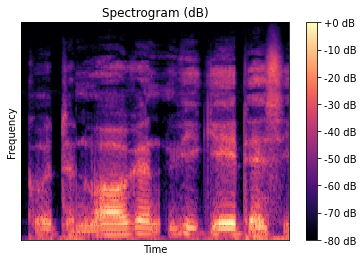

In [15]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 128, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

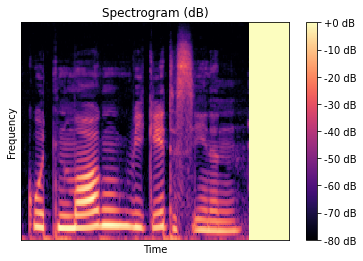

In [16]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 128, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

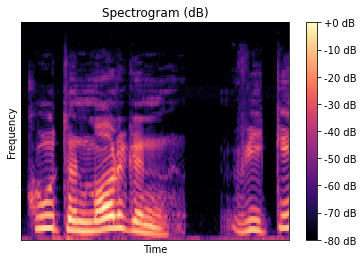

In [17]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(Y_valid[0])
librosa.display.specshow(test_data[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [18]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet34(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256,128),
                             nn.BatchNorm1d(128),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(128,64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 128, 300), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 150]           9,408
       BatchNorm2d-2          [-1, 64, 64, 150]             128
              ReLU-3          [-1, 64, 64, 150]               0
         MaxPool2d-4           [-1, 64, 32, 75]               0
            Conv2d-5           [-1, 64, 32, 75]          36,864
       BatchNorm2d-6           [-1, 64, 32, 75]             128
              ReLU-7           [-1, 64, 32, 75]               0
            Conv2d-8           [-1, 64, 32, 75]          36,864
       BatchNorm2d-9           [-1, 64, 32, 75]             128
             ReLU-10           [-1, 64, 32, 75]               0
       BasicBlock-11           [-1, 64, 32, 75]               0
           Conv2d-12           [-1, 64, 32, 75]          36,864
      BatchNorm2d-13           [-1, 64, 32, 75]             128
             ReLU-14           [-1, 64,

In [20]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [21]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [22]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [17]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_'+str(data_ind)+'_300.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            
            


../../checkpoint/checkpoint_melspectro_resnet18_true_ros_1_300.pt
[1 교차검증] 학습 시작
 ----- 


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\miniconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_40788/3418008601.py", line 25, in <module>
    train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_40788/1868480107.py", line 11, in train
    output = model(image) # model로 output을 계산
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torchvision\models\resnet.py", line 249, in forward
    return self._forward_impl(x)
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torchvision\models\resnet.py", line 233, in _forward_impl
    x = self.bn1(x)
  File "D:\miniconda3\envs\local_torch\lib\site

TypeError: object of type 'NoneType' has no len()

In [23]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용
###### train size 변경된 데이터

train_accs = []
valid_accs = []


train_accs_list = []
valid_accs_list = []

train_loss_list = []
valid_loss_list = []






for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_'+str(data_ind)+'_300_size3.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    train_accs_log = []
    valid_accs_log = []

    train_loss_log = []
    valid_loss_log = []

    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)
        
        train_accs_log.append(train_accuracy)
        valid_accs_log.append(valid_accuracy)
        
        train_loss_log.append(train_loss)
        valid_loss_log.append(valid_loss)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            

    train_accs_list.append(train_accs_log)
    valid_accs_list.append(valid_accs_log)
    
    train_loss_list.append(train_loss_log)
    valid_loss_list.append(valid_loss_log)




../../checkpoint/checkpoint_melspectro_resnet18_true_ros_1_300_size3.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0442	 Train Acc:56.50 %  | 	Valid Loss:0.0409 	Valid Acc: 65.67 %

Validation loss decreased (inf --> 0.040943).  Saving model ...

[EPOCH:2]	 Train Loss:0.0428	 Train Acc:60.00 %  | 	Valid Loss:0.0402 	Valid Acc: 72.00 %

Validation loss decreased (0.040943 --> 0.040247).  Saving model ...

[EPOCH:3]	 Train Loss:0.0404	 Train Acc:64.00 %  | 	Valid Loss:0.0386 	Valid Acc: 74.00 %

Validation loss decreased (0.040247 --> 0.038570).  Saving model ...

[EPOCH:4]	 Train Loss:0.0385	 Train Acc:66.33 %  | 	Valid Loss:0.0380 	Valid Acc: 71.00 %

Validation loss decreased (0.038570 --> 0.037994).  Saving model ...

[EPOCH:5]	 Train Loss:0.0368	 Train Acc:69.25 %  | 	Valid Loss:0.0357 	Valid Acc: 78.33 %

Validation loss decreased (0.037994 --> 0.035697).  Saving model ...

[EPOCH:6]	 Train Loss:0.0357	 Train Acc:71.00 %  | 	Valid Loss:0.0336 	Valid Acc: 78.67 %

Validation lo


[EPOCH:12]	 Train Loss:0.0175	 Train Acc:92.00 %  | 	Valid Loss:0.0275 	Valid Acc: 81.33 %

EarlyStopping counter: 2 out of 5

[EPOCH:13]	 Train Loss:0.0158	 Train Acc:93.67 %  | 	Valid Loss:0.0239 	Valid Acc: 83.00 %

Validation loss decreased (0.025832 --> 0.023868).  Saving model ...

[EPOCH:14]	 Train Loss:0.0145	 Train Acc:95.00 %  | 	Valid Loss:0.0243 	Valid Acc: 84.33 %

EarlyStopping counter: 1 out of 5

[EPOCH:15]	 Train Loss:0.0130	 Train Acc:95.33 %  | 	Valid Loss:0.0246 	Valid Acc: 83.33 %

EarlyStopping counter: 2 out of 5

[EPOCH:16]	 Train Loss:0.0120	 Train Acc:96.42 %  | 	Valid Loss:0.0254 	Valid Acc: 80.67 %

EarlyStopping counter: 3 out of 5

[EPOCH:17]	 Train Loss:0.0112	 Train Acc:96.67 %  | 	Valid Loss:0.0234 	Valid Acc: 86.67 %

Validation loss decreased (0.023868 --> 0.023445).  Saving model ...

[EPOCH:18]	 Train Loss:0.0098	 Train Acc:96.92 %  | 	Valid Loss:0.0256 	Valid Acc: 82.00 %

EarlyStopping counter: 1 out of 5

[EPOCH:19]	 Train Loss:0.0087	 Train Acc


[EPOCH:19]	 Train Loss:0.0120	 Train Acc:96.25 %  | 	Valid Loss:0.0308 	Valid Acc: 80.67 %

EarlyStopping counter: 4 out of 5

[EPOCH:20]	 Train Loss:0.0101	 Train Acc:97.50 %  | 	Valid Loss:0.0238 	Valid Acc: 84.33 %

EarlyStopping counter: 5 out of 5
[5 교차검증] Early stopping


In [55]:
all_train_accs = []
all_valid_accs = []

all_train_loss_list = []
all_valid_loss_list = []


In [99]:
all_train_accs.appendq(train_accs_list[4])
all_valid_accs.append(valid_accs_list[4])

all_train_loss_list.append(train_loss_list[4])
all_valid_loss_list.append(valid_loss_list[4])



In [101]:
all_train_accs
all_valid_accs
all_train_loss_list
all_valid_loss_list

[[0.04795058310031891,
  0.04466769874095917,
  0.04595980703830719,
  0.042366627454757694,
  0.04228638231754303,
  0.04176725804805756,
  0.04021178901195526,
  0.03924745559692383,
  0.03960374563932419,
  0.039569055438041685,
  0.039459053874015805,
  0.03801554322242737,
  0.03880182385444641,
  0.036240963637828826,
  0.03871599465608597,
  0.036538616716861726,
  0.035067003965377805,
  0.03533331364393234,
  0.03587373167276382,
  0.032789632976055146,
  0.03474006712436676,
  0.031906072497367856,
  0.03670377612113953,
  0.02946846395730972,
  0.029854364097118377,
  0.030371238589286805,
  0.03094083786010742,
  0.030538543462753295,
  0.030244445204734804],
 [0.04396908283233643,
  0.04134914845228195,
  0.040657799839973446,
  0.03729718238115311,
  0.03576665088534355,
  0.034948120415210726,
  0.032927991151809693,
  0.034125274270772936,
  0.02951663911342621,
  0.030175272226333618,
  0.030953909307718276,
  0.02843052342534065,
  0.028366589695215227,
  0.0291523377

In [103]:
import pickle
with open('list1.txt', 'wb') as f:
    pickle.dump(all_train_accs, f)
with open('list2.txt', 'wb') as f:
    pickle.dump(all_valid_accs, f)
with open('list3.txt', 'wb') as f:
    pickle.dump(all_train_loss_list, f)
with open('list4.txt', 'wb') as f:
    pickle.dump(all_valid_loss_list, f)


In [104]:
with open('list1.txt', 'rb') as f:
    all_train_accs = pickle.load(f)
with open('list2.txt', 'rb') as f:
    all_train_accs = pickle.load(f)
with open('list3.txt', 'rb') as f:
    all_train_loss_list = pickle.load(f)
with open('list4.txt', 'rb') as f:
    all_valid_loss_list = pickle.load(f)

# Model 결과 확인

In [24]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 94.3333 |	 valid ACC: 84.6667 
[2 교차검증] train ACC : 96.0000 |	 valid ACC: 83.6667 
[3 교차검증] train ACC : 96.6667 |	 valid ACC: 86.6667 
[4 교차검증] train ACC : 96.2500 |	 valid ACC: 81.6667 
[5 교차검증] train ACC : 95.0833 |	 valid ACC: 84.0000 
평균 검증 정확도 84.13333333333334 %


# Model Test

- test set
- confusion matrix

In [25]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [26]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_'+str(data_ind)+'_300_size3.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 82.2404% 
Precision (pathology 예측한 것중 맞는 것) : 0.8884
recall (실제 pathology 중  예측이 맞는 것) : 0.8326
f score : 0.8090 
[[199  40]
 [ 25 102]]
-----
2번 모델
Accuracy : 83.0601% 
Precision (pathology 예측한 것중 맞는 것) : 0.8498
recall (실제 pathology 중  예측이 맞는 것) : 0.8996
f score : 0.8078 
[[215  24]
 [ 38  89]]
-----
3번 모델
Accuracy : 83.3333% 
Precision (pathology 예측한 것중 맞는 것) : 0.8938
recall (실제 pathology 중  예측이 맞는 것) : 0.8452
f score : 0.8202 
[[202  37]
 [ 24 103]]
-----
4번 모델
Accuracy : 79.5082% 
Precision (pathology 예측한 것중 맞는 것) : 0.8228
recall (실제 pathology 중  예측이 맞는 것) : 0.8745
f score : 0.7670 
[[209  30]
 [ 45  82]]
-----
5번 모델
Accuracy : 83.3333% 
Precision (pathology 예측한 것중 맞는 것) : 0.8589
recall (실제 pathology 중  예측이 맞는 것) : 0.8912
f score : 0.8129 
[[213  26]
 [ 35  92]]
-----
평균 acc : 0.8230
평균 f1score : 0.8034


# 기타

In [32]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [33]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [34]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])

In [ ]:
all_train_accs
all_valid_accs

all_train_loss_list
all_valid_loss_list



In [113]:
all_train_accs

[[50.0,
  74.0,
  71.0,
  77.0,
  77.0,
  77.0,
  77.0,
  76.0,
  76.0,
  79.0,
  81.0,
  83.0,
  81.0,
  80.0,
  83.0,
  78.0,
  83.0,
  80.0,
  76.0,
  79.0,
  80.0,
  84.0,
  76.0,
  84.0,
  86.0,
  81.0,
  86.0,
  80.0,
  84.0],
 [55.5,
  75.5,
  74.5,
  78.5,
  80.5,
  79.5,
  83.5,
  80.0,
  85.5,
  83.0,
  78.5,
  82.5,
  79.0,
  80.5,
  79.5,
  81.0,
  80.0,
  83.5,
  83.5,
  86.0,
  83.5,
  82.0,
  86.0,
  86.0,
  78.5,
  83.0,
  69.5,
  78.0]]

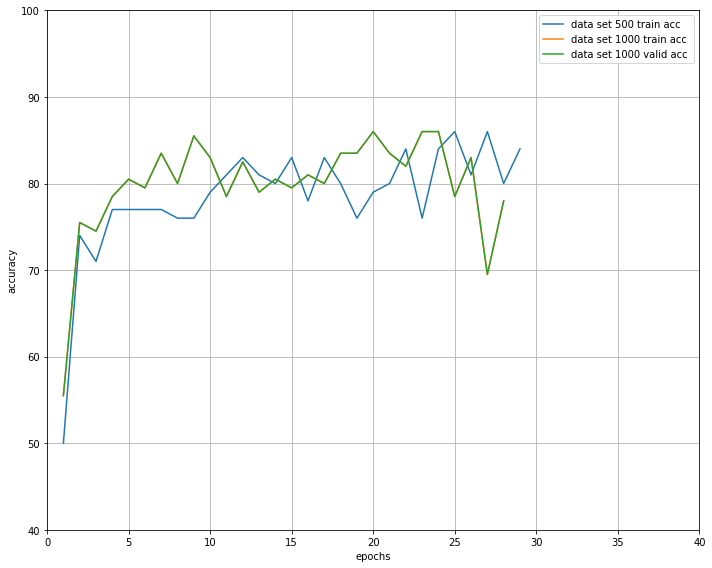

In [116]:
#resnet34 pretrained true
#train set에 따른

#accuracy 그래프

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(all_train_accs[0])+1 ),all_train_accs[0],label='data set 500 train acc')
plt.plot(range(1,len(all_valid_accs[0])+1 ),all_valid_accs[0],label='data set 500 valid acc ')

plt.plot(range(1,len(all_train_accs[1])+1 ),all_train_accs[1],label='data set 1000 train acc')
plt.plot(range(1,len(all_valid_accs[1])+1 ),all_valid_accs[1],label='data set 1000 valid acc ')




plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.ylim(40,100 )# 일정한 scale
plt.xlim(0,40) # 일정 sclae로

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('cnn_loss_flot.png',bbox_inches='tight')


In [45]:
len(all_valid_loss_list[0])

116

In [43]:
range(1,len(all_valid_loss_list[0])+1 )

range(1, 117)

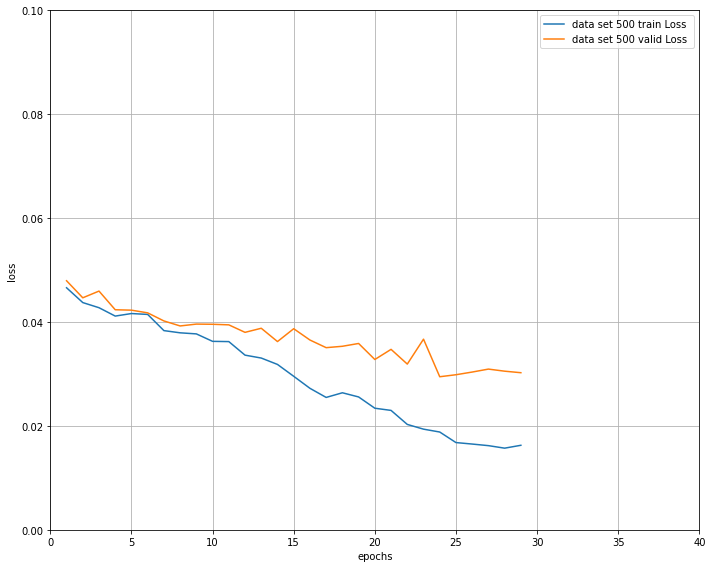

In [65]:
#resnet34 pretrained true
#훈련이 진행되는 과정에 따라 loss를 시각화

fig = plt.figure(figsize=(10,8))

plt.plot(range(1,len(all_train_loss_list[0])+1 ),all_train_loss_list[0],label='data set 500 train Loss')
plt.plot(range(1,len(all_valid_loss_list[0])+1 ),all_valid_loss_list[0],label='data set 500 valid Loss ')

plt.plot(range(1,len(all_train_loss_list[1])+1 ),all_train_loss_list[0],label='data set 1000 train Loss')
plt.plot(range(1,len(all_valid_loss_list[1])+1 ),all_valid_loss_list[0],label='data set 1000 valid Loss ')


plt.xlabel('epochs')
plt.ylabel('loss')

plt.ylim(0.0,0.1)# 일정한 scale
plt.xlim(0,40) # 일정 sclae로

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('cnn_loss_flot.png',bbox_inches='tight')
